# ⚠️ Demonstrations-Notebook

**Zweck:** Dieses Notebook demonstriert die Methodologie mit Sample/synthetischen Daten.

**Wichtige Hinweise:**
- Alle gezeigten Daten sind synthetisch oder für Demonstrationszwecke anonymisiert
- Echte Klienteninformationen, Maschinen-IDs und Anlagendetails wurden entfernt
- Ergebnisse illustrieren potentielle Outcomes und technischen Ansatz

**Kontext:**
- Entwickelt während: Data Science Praktikum bei Data Coffee GmbH (Juni-September 2025)
- Projekt: Forschungsprototyp für LLM-Integration mit industrieller Zeitreihenanalyse

**Performance-Angaben:**
Alle Genauigkeitsverbesserungen oder Kosteneinsparungszahlen repräsentieren:
- Testergebnisse bei Validierungsdatensätzen
- Potentielle Outcomes basierend auf ähnlichen Implementierungen
- NICHT garantierte Produktionsergebnisse

---

# CNC Einzelmaschinen-Analyse - Universelles Template
## Automatisierte Fertigungsdatenanalyse für eine Maschine

**📋 Dieses Notebook analysiert eine einzelne CNC-Maschine und erstellt automatisch:**
- ✅ Zykluszeitanalyse ("Wie lange eine Zykluszeit ist")
- ✅ Rüstzeitanalyse ("Wie lange die Rüstzeiten sind")
- ✅ Variablenabhängigkeitsanalyse ("Wie Abhängigkeiten sich darstellen")
- ✅ Automatisierten Bericht mit Empfehlungen
- ✅ Grafana-Style Dashboard

**🔧 Verwendung:**
1. Dateipfad in der nächsten Zelle anpassen
2. Alle Zellen der Reihe nach ausführen
3. Automatische Analyse und Berichtserstellung

**⚙️ Geschäftslogik:**
- **Zykluszeit**: exec="ACTIVE" Perioden mit Programmkontext
- **Rüstzeit**: exec="READY"/"FEED" mit Programmwechseln
- **Abhängigkeiten**: Korrelationsanalyse der Prozessvariablen

In [ ]:
# =========================================
# KONFIGURATION - HIER DATEIPFAD ANPASSEN
# =========================================

# 📁 Dateipfad zur CSV-Datei der zu analysierenden Maschine
MACHINE_DATA_PATH = '../Industrial_Signal_Processing_TimeSeriesAnalysis/data_and_eda/sample_cnc_data.xlsx'  # ← HIER PFAD ÄNDERN

# 📊 Maschinenname für Berichte (optional - wird automatisch aus Dateiname extrahiert)
MACHINE_NAME = None  # None = automatisch, oder z.B. 'CNC_Produktion_Halle_A'

# 📈 Analyseparameter
MIN_CYCLE_DURATION = 0.1    # Minimale Zykluszeit in Minuten
MAX_CYCLE_DURATION = 480    # Maximale Zykluszeit in Minuten (8 Stunden)
MIN_SETUP_DURATION = 0.5    # Minimale Rüstzeit in Minuten
MAX_SETUP_DURATION = 480    # Maximale Rüstzeit in Minuten

# 📋 Exportoptionen
EXPORT_REPORTS = True       # JSON-Berichte exportieren
EXPORT_SUMMARY = True       # Text-Zusammenfassung exportieren
SHOW_DASHBOARD = True       # Grafana-Style Dashboard anzeigen

print("✅ Konfiguration geladen")
print(f"📁 Analysiere Datei: {MACHINE_DATA_PATH}")
print(f"📊 Maschinenname: {MACHINE_NAME or 'Wird automatisch extrahiert'}")

In [24]:
# Erforderliche Bibliotheken importieren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta
import json
from scipy import stats
from scipy.stats import pearsonr
import re

# Konfiguration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', 20)
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("✅ Bibliotheken erfolgreich geladen")
print(f"✅ Universelle Einzelmaschinen-Analyse bereit")

✅ Bibliotheken erfolgreich geladen
✅ Universelle Einzelmaschinen-Analyse bereit


## 1. Datenladen und Grundanalyse

In [ ]:
def load_and_analyze_machine_data(file_path, machine_name=None):
    """Lade Maschinendaten und führe Grundanalyse durch"""
    file_path = Path(file_path)
    
    # Extrahiere Maschinenname aus Dateiname falls nicht angegeben
    if machine_name is None:
        machine_name = file_path.stem.replace('.csv', '')
        # Bereinige Maschinenname
        machine_name = re.sub(r'[_\d\.-]+$', '', machine_name)
    
    print("=" * 70)
    print(f"📊 LADE MASCHINENDATEN: {machine_name}")
    print("=" * 70)
    
    try:
        # Lade Excel-Datei (ersten Blatt oder spezifischen Namen)
        # Wenn sheet_name=None, wird ein Dict zurückgegeben. Wir brauchen einen DataFrame.
        excel_data = pd.read_excel(file_path, sheet_name=0)  # Ersten Blatt laden
        df = excel_data
        print(f"✅ Datei erfolgreich geladen: {file_path.name}")
        
        # Zeitstempel konvertieren
        if 'time' in df.columns:
            df['datetime'] = pd.to_datetime(df['time'], unit='ns')
            df['date'] = df['datetime'].dt.date
            df['hour'] = df['datetime'].dt.hour
        else:
            raise ValueError("Keine 'time' Spalte gefunden")
        
        # Grundstatistiken
        print(f"\n📈 GRUNDSTATISTIKEN:")
        print(f"   Gesamtdatensätze: {len(df):,}")
        print(f"   Zeitbereich: {df['datetime'].min().strftime('%Y-%m-%d %H:%M')} bis {df['datetime'].max().strftime('%Y-%m-%d %H:%M')}")
        print(f"   Analysedauer: {(df['datetime'].max() - df['datetime'].min()).total_seconds() / 3600:.1f} Stunden")
        print(f"   Datenpunkte pro Stunde: {len(df) / ((df['datetime'].max() - df['datetime'].min()).total_seconds() / 3600):.0f}")
        
        # Prüfe wichtige Geschäftsvariablen
        key_vars = ['exec_STRING', 'pgm_STRING', 'mode_STRING']
        available_vars = [var for var in key_vars if var in df.columns]
        missing_vars = [var for var in key_vars if var not in df.columns]
        
        print(f"\n🔍 GESCHÄFTSVARIABLEN:")
        print(f"   Verfügbar: {available_vars}")
        if missing_vars:
            print(f"   ⚠️ Fehlend: {missing_vars}")
        
        # Analysiere exec_STRING Status
        if 'exec_STRING' in df.columns:
            exec_counts = df['exec_STRING'].value_counts()
            print(f"\n⚙️ MASCHINENSTATUS (exec_STRING):")
            for status, count in exec_counts.head().items():
                percentage = (count / len(df)) * 100
                print(f"   {status}: {count:,} ({percentage:.1f}%)")
        
        # Analysiere Programmvielfalt
        if 'pgm_STRING' in df.columns:
            unique_programs = df['pgm_STRING'].nunique()
            print(f"\n🔧 PROGRAMMANALYSE (pgm_STRING):")
            print(f"   Eindeutige Programme: {unique_programs}")
            if unique_programs <= 15:
                program_counts = df['pgm_STRING'].value_counts().head(10)
                print(f"   Top Programme:")
                for prog, count in program_counts.items():
                    percentage = (count / len(df)) * 100
                    print(f"     {prog}: {count:,} ({percentage:.1f}%)")
        
        # Datenqualitätsprüfung
        print(f"\n📊 DATENQUALITÄT:")
        total_cols = len(df.columns)
        numeric_cols = len(df.select_dtypes(include=[np.number]).columns)
        print(f"   Gesamtspalten: {total_cols}")
        print(f"   Numerische Spalten: {numeric_cols}")
        
        # Prüfe auf fehlende Werte in wichtigen Spalten
        for col in available_vars:
            missing_pct = (df[col].isnull().sum() / len(df)) * 100
            if missing_pct > 0:
                print(f"   {col}: {missing_pct:.1f}% fehlende Werte")
        
        return df, machine_name
        
    except Exception as e:
        print(f"❌ Fehler beim Laden der Datei: {str(e)}")
        return None, None

# Lade Maschinendaten
df, machine_name = load_and_analyze_machine_data(MACHINE_DATA_PATH, MACHINE_NAME)

if df is not None:
    print(f"\n✅ Daten erfolgreich geladen und analysiert für: {machine_name}")
else:
    print(f"\n❌ Fehler: Kann nicht fortfahren ohne gültige Daten")

In [ ]:
df

In [28]:
# Install ydata-profiling if not already installed
try:
    from ydata_profiling import ProfileReport
    print("✅ ydata-profiling bereits installiert")
except ImportError:
    print("📦 Installiere ydata-profiling...")
    import sys
    !{sys.executable} -m pip install ydata-profiling
    print("✅ Installation abgeschlossen!")

✅ ydata-profiling bereits installiert


In [29]:
# Quick check: Verify DataFrame is loaded
print("🔍 DataFrame Status:")
print(f"   DataFrame existiert: {'df' in globals()}")
if 'df' in globals() and df is not None:
    print(f"   Zeilen: {len(df):,}")
    print(f"   Spalten: {len(df.columns)}")
    print(f"   Speicher: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   ✅ Bereit für EDA-Profiling")
else:
    print(f"   ❌ DataFrame nicht geladen - bitte Zellen 1-5 ausführen")

🔍 DataFrame Status:
   DataFrame existiert: True
   Zeilen: 113,855
   Spalten: 9
   Speicher: 39.87 MB
   ✅ Bereit für EDA-Profiling


In [30]:
# Generate the EDA report for the combined dataset
print("🔍 Prüfe ob DataFrame vorhanden ist...")
if df is not None and len(df) > 0:
    print(f"✅ DataFrame gefunden: {len(df):,} Zeilen, {len(df.columns)} Spalten")
    print("📊 Generiere EDA-Bericht (dies kann einige Minuten dauern)...")
    
    from ydata_profiling import ProfileReport
    profile = ProfileReport(df, title="Data profile combined CNC_1 15.08.2025", explorative=True, minimal=False)
    
    # Save it as an HTML file
    output_file = "Data_profile_CNC_1_1508.html"
    profile.to_file(output_file)
    print(f"✅ EDA-Bericht erfolgreich erstellt: {output_file}")
    
    # Display profile in notebook
    profile
else:
    print("❌ Fehler: DataFrame 'df' ist leer oder nicht vorhanden")
    print("   Bitte führen Sie zuerst die Zelle 'load_and_analyze_machine_data' aus")

🔍 Prüfe ob DataFrame vorhanden ist...
✅ DataFrame gefunden: 113,855 Zeilen, 9 Spalten
📊 Generiere EDA-Bericht (dies kann einige Minuten dauern)...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 12.09it/s]



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ EDA-Bericht erfolgreich erstellt: Data_profile_CNC_1_1508.html


In [39]:
profile

## 2. Maschinenstatus-Analyse mit Geschäftslogik

In [ ]:
def analyze_machine_states_single(df, machine_name):
    """Analysiere Maschinenstatus für eine einzelne Maschine"""
    print(f"\n" + "="*70)
    print(f"⚙️ MASCHINENSTATUS-ANALYSE: {machine_name}")
    print("="*70)
    
    if 'exec_STRING' not in df.columns or 'pgm_STRING' not in df.columns:
        print(f"❌ Fehlende erforderliche Spalten (exec_STRING oder pgm_STRING)")
        return None
    
    # Erstelle erweiterten DataFrame für Analyse
    df_analysis = df.copy()
    
    # Definiere Produktionsstatus
    df_analysis['is_active'] = df_analysis['exec_STRING'] == 'ACTIVE'
    df_analysis['is_ready'] = df_analysis['exec_STRING'] == 'READY'
    df_analysis['is_stopped'] = df_analysis['exec_STRING'] == 'STOPPED'
    df_analysis['is_feed'] = df_analysis['exec_STRING'] == 'FEED'
    
    # Erkenne Programmwechsel
    df_analysis['program_changed'] = df_analysis['pgm_STRING'] != df_analysis['pgm_STRING'].shift(1)
    
    # Filtere Perioden
    active_periods = df_analysis[df_analysis['is_active']].copy()
    ready_periods = df_analysis[df_analysis['is_ready']].copy()
    stopped_periods = df_analysis[df_analysis['is_stopped']].copy()
    feed_periods = df_analysis[df_analysis['is_feed']].copy()
    
    # Programmwechsel
    program_changes = df_analysis[df_analysis['program_changed']].copy()
    
    print(f"📊 STATUSVERTEILUNG:")
    print(f"   🟢 ACTIVE (Produktion):   {len(active_periods):,} ({len(active_periods)/len(df)*100:.1f}%)")
    print(f"   🔵 READY (Bereit):        {len(ready_periods):,} ({len(ready_periods)/len(df)*100:.1f}%)")
    print(f"   🟠 STOPPED (Gestoppt):    {len(stopped_periods):,} ({len(stopped_periods)/len(df)*100:.1f}%)")
    print(f"   🟡 FEED (Zuführung):      {len(feed_periods):,} ({len(feed_periods)/len(df)*100:.1f}%)")
    print(f"   🔄 Programmwechsel erkannt: {len(program_changes):,}")
    
    # Produktivitätsbewertung
    active_percentage = (len(active_periods) / len(df)) * 100
    setup_percentage = ((len(ready_periods) + len(feed_periods)) / len(df)) * 100
    
    print(f"\n💡 PRODUKTIVITÄTSBEWERTUNG:")
    if active_percentage > 60:
        print(f"   ✅ Hohe Produktivität ({active_percentage:.1f}% ACTIVE)")
    elif active_percentage > 30:
        print(f"   ⚠️ Mittlere Produktivität ({active_percentage:.1f}% ACTIVE)")
    else:
        print(f"   🔴 Niedrige Produktivität ({active_percentage:.1f}% ACTIVE)")
    
    if setup_percentage > 30:
        print(f"   ⚠️ Hoher Rüstanteil ({setup_percentage:.1f}% READY/FEED)")
    elif setup_percentage > 15:
        print(f"   🟡 Mittlerer Rüstanteil ({setup_percentage:.1f}% READY/FEED)")
    else:
        print(f"   ✅ Geringer Rüstanteil ({setup_percentage:.1f}% READY/FEED)")
    
    return {
        'analysis_df': df_analysis,
        'active_periods': active_periods,
        'ready_periods': ready_periods,
        'stopped_periods': stopped_periods,
        'feed_periods': feed_periods,
        'program_changes': program_changes,
        'stats': {
            'active_percentage': active_percentage,
            'setup_percentage': setup_percentage,
            'active_count': len(active_periods),
            'ready_count': len(ready_periods),
            'stopped_count': len(stopped_periods),
            'feed_count': len(feed_periods),
            'program_changes_count': len(program_changes)
        }
    }

# Analysiere Maschinenstatus
if df is not None:
    machine_states = analyze_machine_states_single(df, machine_name)
    if machine_states:
        print(f"\n✅ Statusanalyse abgeschlossen")
    else:
        print(f"\n❌ Statusanalyse fehlgeschlagen")

## 3. Zykluszeitanalyse - "Wie lange eine Zykluszeit ist"

Klärungsbedarf bei der Zykluszeitanalyse: Definition von Produktionszyklen


Im Rahmen unserer automatisierten Maschinendatenanalyse definieren wir einen neuen Produktionszyklus, wenn eine ACTIVE-Phase nach einer Unterbrechung von mehr als 300 Sekunden (5 Minuten) fortgesetzt wird, selbst bei gleichem Programm.

Dieser Parameter ist entscheidend, da er direkt beeinflusst, wie wir Produktionszyklen voneinander trennen und somit unsere KPIs (z.B. durchschnittliche Zykluszeit, Zyklen pro Stunde) berechnet werden.

Könnten Sie aus Ihrer betrieblichen Erfahrung bitte bestätigen, ob diese 5-Minuten-Regel als Schwellenwert zur Trennung von kurzen, operativen Pausen (z.B. Werkzeugkontrolle) und längeren Stillständen (z.B. Kaffeepause, Materialmangel) für diesen Prozess sinnvoll ist?

Falls es betriebliche Abläufe gibt, die eine Anpassung dieses Wertes nahelegen, lassen Sie es mich bitte wissen.

1. Warum aktuell 300 Sekunden (5 Minuten) gewählt wurden :
Industriestandard: "Wir haben initial einen Wert von 5 Minuten gewählt, da dies eine gängige Best Practice in der Industrie ist. Er dient dazu, kurze, prozessbedingte Mikro-Stillstände von echten Pausen oder ungeplanten Stopps zu unterscheiden."


Vermeidung von Datenverzerrung: "Dieser Schwellenwert verhindert, dass kurze Pausen (z.B. eine schnelle Werkzeugkontrolle) die durchschnittliche Zykluszeit künstlich verlängern. Gleichzeitig sorgt er dafür, dass längere Stopps (z.B. eine Kaffeepause) nicht fälschlicherweise als Teil eines durchgehenden Zyklus gezählt werden."


2. Welche Varianten gibt es und was sind die Konsequenzen? :
Option A: Wert verringern (z.B. auf 120 Sekunden / 2 Minuten)

Wann sinnvoll? "Wenn wir wissen, dass jede prozessinterne Unterbrechung üblicherweise unter 2 Minuten dauert und alles darüber bereits als relevanter Stopp gilt, könnten wir den Wert senken."


Konsequenz: "Dies würde zu einer höheren Anzahl an Zyklen und einer kürzeren durchschnittlichen Zykluszeit führen. Es könnte aber auch dazu führen, dass wir normale, kurze Wartezeiten fälschlicherweise als Zyklusende interpretieren."


Option B: Wert erhöhen (z.B. auf 600 Sekunden / 10 Minuten)

Wann sinnvoll? "Wenn es im Prozess standardmäßige, längere Pausen gibt, die als normal gelten (z.B. eine automatisierte 8-minütige Werkzeugvermessung), oder wenn wir wissen, dass die Standard-Kaffeepause 10 Minuten dauert und diese nicht als Zyklus-Trenner gelten soll."


Konsequenz: "Dies würde zu weniger, aber längeren Zyklen führen, da die Pausen in die Zykluszeit mit eingerechnet werden. Dies könnte die tatsächliche Bearbeitungszeit verschleiern."


In [ ]:
def analyze_cycle_times_single(machine_states, machine_name, min_duration=0.1, max_duration=480):
    """Analysiere Zykluszeiten für eine einzelne Maschine"""
    print(f"\n" + "="*70)
    print(f"🎯 ZYKLUSZEITANALYSE: {machine_name}")
    print(f"📋 Methode: exec='ACTIVE' Perioden mit Programmkontext")
    print("="*70)
    
    if not machine_states:
        print(f"❌ Keine Statusdaten verfügbar")
        return None
    
    active_periods = machine_states['active_periods']
    
    if len(active_periods) < 10:
        print(f"⚠️ Zu wenige ACTIVE Perioden für Analyse: {len(active_periods)}")
        return None
    
    print(f"📊 ROHDATEN:")
    print(f"   ACTIVE Datensätze: {len(active_periods):,}")
    
    # Sortiere nach Zeit
    active_sorted = active_periods.sort_values('datetime')
    
    # Erkenne Produktionszyklen
    cycles = []
    current_cycle_start = None
    current_program = None
    last_time = None
    
    print(f"\n🔍 ZYKLUSERKENNUNG:")
    
    for idx, row in active_sorted.iterrows():
        current_time = row['datetime']
        program = row['pgm_STRING']
        
        # Neuer Zyklus wenn: Programmwechsel oder Pause > 5 Minuten
        if (current_cycle_start is None or 
            program != current_program or 
            (last_time and (current_time - last_time).total_seconds() > 300)):
            
            # Beende vorherigen Zyklus
            if current_cycle_start is not None and last_time is not None:
                cycle_duration = (last_time - current_cycle_start).total_seconds() / 60
                if min_duration <= cycle_duration <= max_duration:
                    cycles.append({
                        'start': current_cycle_start,
                        'end': last_time,
                        'duration_minutes': cycle_duration,
                        'program': current_program
                    })
            
            # Starte neuen Zyklus
            current_cycle_start = current_time
            current_program = program
        
        last_time = current_time
    
    # Letzten Zyklus schließen
    if current_cycle_start is not None and last_time is not None:
        cycle_duration = (last_time - current_cycle_start).total_seconds() / 60
        if min_duration <= cycle_duration <= max_duration:
            cycles.append({
                'start': current_cycle_start,
                'end': last_time,
                'duration_minutes': cycle_duration,
                'program': current_program
            })
    
    if len(cycles) < 3:
        print(f"⚠️ Zu wenige Zyklen erkannt: {len(cycles)}")
        print(f"   Mögliche Ursachen:")
        print(f"   • Sehr lange Produktionsläufe")
        print(f"   • Wenige Programmwechsel")
        print(f"   • Maschine läuft kontinuierlich")
        return None
    
    # Statistische Analyse
    cycle_durations = [c['duration_minutes'] for c in cycles]
    
    mean_cycle = np.mean(cycle_durations)
    median_cycle = np.median(cycle_durations)
    std_cycle = np.std(cycle_durations)
    min_cycle = np.min(cycle_durations)
    max_cycle = np.max(cycle_durations)
    cv = std_cycle / mean_cycle if mean_cycle > 0 else 0
    
    # Programmspezifische Analyse
    program_cycles = {}
    for cycle in cycles:
        prog = cycle['program']
        if prog not in program_cycles:
            program_cycles[prog] = []
        program_cycles[prog].append(cycle['duration_minutes'])
    
    # Produktionsrate
    total_hours = (active_sorted['datetime'].max() - active_sorted['datetime'].min()).total_seconds() / 3600
    cycles_per_hour = len(cycles) / total_hours if total_hours > 0 else 0
    
    print(f"   Erkannte Zyklen: {len(cycles)}")
    print(f"   Zeitraum: {total_hours:.1f} Stunden")
    
    print(f"\n📈 ZYKLUSZEITSTATISTIKEN:")
    print(f"   Durchschnitt: {mean_cycle:.2f} Minuten ({mean_cycle*60:.0f} Sekunden)")
    print(f"   Median: {median_cycle:.2f} Minuten")
    print(f"   Bereich: {min_cycle:.2f} - {max_cycle:.2f} Minuten")
    print(f"   Standardabweichung: {std_cycle:.2f} Minuten")
    print(f"   Variationskoeffizient: {cv:.3f}")
    
    print(f"\n⚡ PRODUKTIONSLEISTUNG:")
    print(f"   Zyklen pro Stunde: {cycles_per_hour:.1f}")
    print(f"   Teile pro Tag (24h): {cycles_per_hour * 24:.0f}")
    print(f"   Verarbeitete Programme: {len(program_cycles)}")
    
    # Konsistenzbewertung
    print(f"\n💡 BEWERTUNG:")
    if cv < 0.2:
        print(f"   ✅ Sehr konsistente Zykluszeiten (CV: {cv:.3f})")
    elif cv < 0.5:
        print(f"   🟡 Mäßig konsistente Zykluszeiten (CV: {cv:.3f})")
    else:
        print(f"   🔴 Unkonssistente Zykluszeiten - Prozess prüfen (CV: {cv:.3f})")
    
    # Programmspezifische Details
    if len(program_cycles) > 1:
        print(f"\n🔧 PROGRAMMSPEZIFISCHE ZYKLUSZEITEN:")
        for prog, durations in sorted(program_cycles.items(), key=lambda x: len(x[1]), reverse=True)[:5]:
            if len(durations) >= 2:
                avg_time = np.mean(durations)
                print(f"   {prog}: {avg_time:.2f} min (n={len(durations)})")
    
    return {
        'total_cycles': len(cycles),
        'mean_minutes': mean_cycle,
        'median_minutes': median_cycle,
        'std_minutes': std_cycle,
        'min_minutes': min_cycle,
        'max_minutes': max_cycle,
        'coefficient_of_variation': cv,
        'cycles_per_hour': cycles_per_hour,
        'parts_per_day': cycles_per_hour * 24,
        'unique_programs': len(program_cycles),
        'program_cycles': {prog: {
            'count': len(durations),
            'avg_minutes': np.mean(durations),
            'std_minutes': np.std(durations)
        } for prog, durations in program_cycles.items() if len(durations) >= 2},
        'raw_cycles': cycles
    }

# Führe Zykluszeitanalyse durch
if machine_states:
    cycle_analysis = analyze_cycle_times_single(machine_states, machine_name, MIN_CYCLE_DURATION, MAX_CYCLE_DURATION)
    if cycle_analysis:
        print(f"\n✅ Zykluszeitanalyse abgeschlossen")
    else:
        print(f"\n⚠️ Zykluszeitanalyse nicht möglich mit aktuellen Daten")

## 4. Rüstzeitanalyse - "Wie lange die Rüstzeiten sind"

Erklärung der 5-15-30-60 Minuten Business-Logik für die Rüstzeitanalyse
Diese 5-15-30-60-Minuten-Regel ist eine betriebswirtschaftliche Klassifizierung, die auf allgemeinen Benchmarks aus der modernen Fertigung (z.B. Lean Manufacturing, SMED-Prinzipien) basiert. Ihr Hauptzweck ist es, die gemessene durchschnittliche Rüstzeit schnell in eine verständliche und handlungsorientierte Bewertung zu übersetzen.

Im Wesentlichen funktioniert diese Logik wie ein Ampelsystem, das dem Management auf einen Blick zeigt, wo Handlungsbedarf besteht, ohne dass man sich tief in die Rohdaten einarbeiten muss.

Hier ist die Argumentation für jede einzelne Stufe:

Unter 5 Minuten (Bewertung: Exzellent)
Betriebliche Bedeutung: Dies entspricht dem Weltklasse-Niveau nach den SMED-Prinzipien (Single-Minute Exchange of Die). Es zeigt einen hochoptimierten, fast perfekten Rüstprozess. Rüstzeiten in diesem Bereich haben praktisch keinen negativen Einfluss auf die Produktionskapazität.

Unter 15 Minuten (Bewertung: Gut)
Betriebliche Bedeutung: Dies ist ein sehr effizienter und wettbewerbsfähiger Wert. Viele Unternehmen streben dieses Ziel an. Es deutet auf gut organisierte und standardisierte Abläufe hin. Der Zeitverlust ist gering und meist akzeptabel.

Unter 30 Minuten (Bewertung: Akzeptabel)
Betriebliche Bedeutung: Das ist ein typischer und akzeptabler Bereich für viele Standardprozesse. Es ist kein dringendes Problem, aber es gibt noch klares Potenzial für Verbesserungen, um die Maschinenverfügbarkeit weiter zu erhöhen.

Unter 60 Minuten (Bewertung: Verbesserungsbedürftig)
Betriebliche Bedeutung: Eine Rüstzeit von bis zu einer Stunde ist ein klares Zeichen für Ineffizienz. In dieser Zeit geht wertvolle Produktionszeit verloren. Hier sollten gezielte Verbesserungsmaßnahmen (z.B. Kaizen-Workshops) ansetzen, um die Prozesse zu optimieren.

Über 60 Minuten (Bewertung: Schlecht)
Betriebliche Bedeutung: Eine Rüstzeit von über einer Stunde wird als großer Engpass (Flaschenhals) betrachtet. Dies erfordert dringende Aufmerksamkeit, da es die Produktionskapazität und Flexibilität erheblich einschränkt und hohe Kosten verursacht.

Zusammenfassend lässt sich sagen: Diese abgestuften Werte sind bewährte Richtwerte, die eine sofortige Einordnung der Rüst-Performance ermöglichen. Sie sind natürlich nicht absolut und können je nach Komplexität der Maschine und des Produkts angepasst werden, bieten aber eine exzellente und objektive Grundlage für die Prozessbewertung.

In [ ]:
def analyze_setup_times_single(machine_states, machine_name, min_duration=0.5, max_duration=480):
    """Analysiere Rüstzeiten für eine einzelne Maschine"""
    print(f"\n" + "="*70)
    print(f"🔧 RÜSTZEITANALYSE: {machine_name}")
    print(f"📋 Methode: exec='READY'/'FEED' Perioden mit Programmwechseln")
    print("="*70)
    
    if not machine_states:
        print(f"❌ Keine Statusdaten verfügbar")
        return None
    
    df_analysis = machine_states['analysis_df']
    program_changes = machine_states['program_changes']
    
    if len(program_changes) < 2:
        print(f"⚠️ Zu wenige Programmwechsel für Analyse: {len(program_changes)}")
        print(f"   Diese Maschine läuft möglicherweise mit wenigen Programmwechseln")
        return None
    
    print(f"📊 ROHDATEN:")
    print(f"   Programmwechsel gesamt: {len(program_changes):,}")
    
    # Erkenne Rüstperioden
    setup_periods = []
    
    print(f"\n🔍 RÜSTZEITERKENNUNG:")
    
    for idx, change_row in program_changes.iterrows():
        change_time = change_row['datetime']
        new_program = change_row['pgm_STRING']
        
        # Finde nächste ACTIVE Periode nach Programmwechsel
        next_active = df_analysis[
            (df_analysis['datetime'] > change_time) & 
            (df_analysis['is_active'] == True) &
            (df_analysis['pgm_STRING'] == new_program)
        ].sort_values('datetime')
        
        if len(next_active) > 0:
            start_production = next_active.iloc[0]['datetime']
            setup_duration = (start_production - change_time).total_seconds() / 60
            
            # Filtere realistische Rüstzeiten
            if min_duration <= setup_duration <= max_duration:
                # Analysiere Status während Rüstperiode
                setup_data = df_analysis[
                    (df_analysis['datetime'] >= change_time) & 
                    (df_analysis['datetime'] <= start_production)
                ]
                
                setup_states = setup_data['exec_STRING'].value_counts()
                has_setup_indicators = any(state in ['READY', 'FEED', 'STOPPED'] 
                                         for state in setup_states.index)
                
                if has_setup_indicators:
                    setup_periods.append({
                        'program_change_time': change_time,
                        'production_start_time': start_production,
                        'setup_duration_minutes': setup_duration,
                        'new_program': new_program,
                        'setup_states': dict(setup_states),
                        'setup_records': len(setup_data)
                    })
    
    if len(setup_periods) < 3:
        print(f"⚠️ Zu wenige Rüstperioden erkannt: {len(setup_periods)}")
        print(f"   Mögliche Ursachen:")
        print(f"   • Seltene Programmwechsel")
        print(f"   • Sehr kurze oder sehr lange Rüstzeiten")
        print(f"   • Maschine läuft hauptsächlich ein Programm")
        return None
    
    # Entferne Ausreißer
    setup_durations = [s['setup_duration_minutes'] for s in setup_periods]
    
    Q1 = np.percentile(setup_durations, 25)
    Q3 = np.percentile(setup_durations, 75)
    IQR = Q3 - Q1
    lower_bound = max(min_duration, Q1 - 1.5*IQR)
    upper_bound = min(max_duration, Q3 + 1.5*IQR)
    
    filtered_setups = [d for d in setup_durations if lower_bound <= d <= upper_bound]
    
    if len(filtered_setups) < 3:
        print(f"⚠️ Zu wenige gültige Rüstzeiten nach Ausreißer-Entfernung: {len(filtered_setups)}")
        return None
    
    # Statistische Analyse
    mean_setup = np.mean(filtered_setups)
    median_setup = np.median(filtered_setups)
    std_setup = np.std(filtered_setups)
    min_setup = np.min(filtered_setups)
    max_setup = np.max(filtered_setups)
    
    # Rüsthäufigkeit
    total_hours = (df_analysis['datetime'].max() - df_analysis['datetime'].min()).total_seconds() / 3600
    setups_per_day = (len(filtered_setups) / total_hours) * 24
    
    print(f"   Erkannte Rüstperioden: {len(setup_periods)}")
    print(f"   Gültige nach Filterung: {len(filtered_setups)}")
    print(f"   Entfernte Ausreißer: {len(setup_durations) - len(filtered_setups)}")
    
    print(f"\n📈 RÜSTZEITSTATISTIKEN:")
    print(f"   Durchschnitt: {mean_setup:.2f} Minuten ({mean_setup*60:.0f} Sekunden)")
    print(f"   Median: {median_setup:.2f} Minuten")
    print(f"   Bereich: {min_setup:.2f} - {max_setup:.2f} Minuten")
    print(f"   Standardabweichung: {std_setup:.2f} Minuten")
    
    print(f"\n🔄 RÜSTHÄUFIGKEIT:")
    print(f"   Rüstvorgänge pro Tag: {setups_per_day:.1f}")
    print(f"   Rüstvorgänge pro Woche: {setups_per_day * 7:.1f}")
    print(f"   Durchschnittlicher Abstand: {24 / setups_per_day if setups_per_day > 0 else 0:.1f} Stunden")
    
    # Effizienzbewertung
    print(f"\n💡 RÜSTEFFIZIENZ-BEWERTUNG:")
    if mean_setup < 5:
        efficiency = "Exzellent"
        print(f"   ✅ Exzellente Rüsteffizienz (< 5 Minuten)")
    elif mean_setup < 15:
        efficiency = "Gut"
        print(f"   🟢 Gute Rüsteffizienz (< 15 Minuten)")
    elif mean_setup < 30:
        efficiency = "Akzeptabel"
        print(f"   🟡 Akzeptable Rüsteffizienz (< 30 Minuten)")
    elif mean_setup < 60:
        efficiency = "Verbesserungsbedürftig"
        print(f"   🟠 Verbesserungsbedürftige Rüsteffizienz (< 60 Minuten)")
    else:
        efficiency = "Schlecht"
        print(f"   🔴 Schlechte Rüsteffizienz (> 60 Minuten) - Dringend optimieren!")
    
    # Täglicher Rüstzeitverlust
    daily_setup_time = setups_per_day * mean_setup / 60  # in Stunden
    print(f"\n⏱️ ZEITAUSWIRKUNG:")
    print(f"   Tägliche Rüstzeit: {daily_setup_time:.1f} Stunden")
    print(f"   Rüstzeit-Anteil am Tag: {(daily_setup_time / 24) * 100:.1f}%")
    
    if daily_setup_time > 4:
        print(f"   ⚠️ Hoher Rüstzeitverlust - Batch-Produktion erwägen")
    elif daily_setup_time > 2:
        print(f"   🟡 Mittlerer Rüstzeitverlust - Überwachung empfohlen")
    else:
        print(f"   ✅ Geringer Rüstzeitverlust")
    
    # Beispiel-Rüstübergänge
    if len(setup_periods) > 0:
        print(f"\n🔧 BEISPIEL-RÜSTÜBERGÄNGE:")
        for i, period in enumerate(setup_periods[:3], 1):
            print(f"   {i}. → {period['new_program']}: {period['setup_duration_minutes']:.1f} min")
    
    return {
        'total_setups': len(setup_periods),
        'valid_setups': len(filtered_setups),
        'mean_minutes': mean_setup,
        'median_minutes': median_setup,
        'std_minutes': std_setup,
        'min_minutes': min_setup,
        'max_minutes': max_setup,
        'setups_per_day': setups_per_day,
        'daily_setup_hours': daily_setup_time,
        'efficiency': efficiency,
        'efficiency_rating': ('Exzellent' if mean_setup < 5 else 
                             'Gut' if mean_setup < 15 else 
                             'Akzeptabel' if mean_setup < 30 else 
                             'Verbesserungsbedürftig' if mean_setup < 60 else 'Schlecht'),
        'raw_setup_periods': setup_periods
    }

# Führe Rüstzeitanalyse durch
if machine_states:
    setup_analysis = analyze_setup_times_single(machine_states, machine_name, MIN_SETUP_DURATION, MAX_SETUP_DURATION)
    if setup_analysis:
        print(f"\n✅ Rüstzeitanalyse abgeschlossen")
    else:
        print(f"\n⚠️ Rüstzeitanalyse nicht möglich mit aktuellen Daten")

## 5. Variablenabhängigkeitsanalyse - "Wie Abhängigkeiten sich darstellen"

In [41]:
# 🔍 DIAGNOSE: Welche Spalten sind numerisch?
print("="*70)
print("🔍 DIAGNOSE: NUMERISCHE SPALTEN")
print("="*70)

if df is not None:
    # Alle Spalten zeigen
    print(f"\n📋 ALLE SPALTEN ({len(df.columns)}):")
    for i, col in enumerate(df.columns, 1):
        dtype = df[col].dtype
        unique = df[col].nunique()
        missing_pct = (df[col].isnull().sum() / len(df)) * 100
        print(f"   {i:2d}. {col:30s} | Typ: {str(dtype):10s} | Eindeutig: {unique:5d} | Fehlend: {missing_pct:5.1f}%")
    
    # Numerische Spalten
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(f"\n📊 NUMERISCHE SPALTEN ({len(numeric_cols)}):")
    for col in numeric_cols:
        print(f"   - {col}")
    
    # String-Spalten
    string_cols = df.select_dtypes(include=['object', 'string']).columns
    print(f"\n📝 STRING-SPALTEN ({len(string_cols)}):")
    for col in string_cols:
        print(f"   - {col}")
else:
    print("❌ DataFrame nicht geladen!")

🔍 DIAGNOSE: NUMERISCHE SPALTEN

📋 ALLE SPALTEN (9):
    1. ts_utc                         | Typ: object     | Eindeutig: 113855 | Fehlend:   0.0%
    2. time                           | Typ: int64      | Eindeutig: 113855 | Fehlend:   0.0%
    3. pgm_STRING                     | Typ: object     | Eindeutig:     5 | Fehlend:   0.0%
    4. mode_STRING                    | Typ: object     | Eindeutig:     2 | Fehlend:   0.0%
    5. exec_STRING                    | Typ: object     | Eindeutig:     6 | Fehlend:   0.0%
    6. ctime_REAL                     | Typ: float64    | Eindeutig:  5354 | Fehlend:   2.5%
    7. datetime                       | Typ: datetime64[ns] | Eindeutig: 113855 | Fehlend:   0.0%
    8. date                           | Typ: object     | Eindeutig:     4 | Fehlend:   0.0%
    9. hour                           | Typ: int32      | Eindeutig:    24 | Fehlend:   0.0%

📊 NUMERISCHE SPALTEN (3):
   - time
   - ctime_REAL
   - hour

📝 STRING-SPALTEN (5):
   - ts_utc
   - p

1. Bedeutung des p-Wertes (Statistische Signifikanz)
Das Problem: Nur weil zwei Variablen in den Daten eine Korrelation (z.B. r = 0.4) aufweisen, heißt das nicht automatisch, dass es eine echte, physikalische oder prozessbedingte Beziehung zwischen ihnen gibt. Es könnte auch reiner Zufall sein.

Die Rolle des p-Wertes: Der p-Wert beantwortet eine entscheidende Frage:

"Wie hoch ist die Wahrscheinlichkeit, dass wir diese Korrelation nur durch Zufall in unseren Daten sehen, obwohl in der Realität gar kein Zusammenhang besteht?"

Die Geschäftsregel (p < 0.05):
In der Statistik gilt ein p-Wert von unter 0.05 (oder 5 %) als Schwelle.

Wenn p < 0.05: Die Wahrscheinlichkeit, dass der Zusammenhang nur Zufall ist, liegt unter 5 %. Wir sind uns also ausreichend sicher, dass die Beziehung statistisch signifikant (also "echt") ist. Nur solche "echten" Zusammenhänge werden in die finale Auswertung aufgenommen.

Wenn p ≥ 0.05: Die Wahrscheinlichkeit eines Zufallstreffers ist zu hoch. Wir verwerfen diese Korrelation, auch wenn der r-Wert hoch erscheint, da sie nicht verlässlich ist.

Warum wird der p-Wert nur für "ausreichend starke" Paare berechnet?
Der Code prüft erst, ob |r| >= 0.3 ist, und berechnet danach den p-Wert. Das hat zwei Gründe:

Effizienz: Die Berechnung des p-Wertes ist rechenintensiv. Es ist viel schneller, zuerst die uninteressanten, sehr schwachen Korrelationen herauszufiltern.

Relevanz: Eine sehr schwache Korrelation (z.B. r = 0.08) ist für das Geschäft meistens irrelevant, selbst wenn sie statistisch signifikant ist. Der Fokus liegt auf Beziehungen, die eine praktische Bedeutung haben könnten.

2. Klassifizierung der Korrelationsstärke (stark, mäßig, schwach)
Das Problem: Ein reiner Zahlenwert wie "r = 0.62" ist für einen Manager oder Prozessverantwortlichen nicht sofort intuitiv. Ist das gut? Ist das wichtig?

Die Lösung (Klassifizierung):
Die Einteilung in "stark", "mäßig" und "schwach" übersetzt die statistische Zahl in eine verständliche, betriebswirtschaftliche Kategorie. Die gewählten Schwellenwerte (0.3, 0.5, 0.7) sind keine willkürlichen Zahlen, sondern etablierte Richtwerte in der Statistik (bekannt als "Cohen's Faustregeln"), um die Stärke eines Effekts zu interpretieren.

Stark (stark, |r| > 0.7):

Bedeutung: Es besteht eine sehr enge und verlässliche Beziehung. Wenn sich eine Variable ändert, ändert sich die andere sehr vorhersagbar mit.

Nutzen: Exzellent für prädiktive Modelle und Prozesssteuerung. Wenn wir einen Wert kennen, können wir den anderen mit hoher Sicherheit schätzen.

Mäßig (mäßig, 0.5 < |r| ≤ 0.7):

Bedeutung: Es gibt eine deutliche Beziehung, aber sie ist nicht perfekt. Die Variablen beeinflussen sich gegenseitig, aber es gibt auch andere Faktoren, die eine Rolle spielen.

Nutzen: Sehr gut für die Prozessüberwachung (Monitoring). Abweichungen in diesen Paaren sind oft wichtige Hinweise auf Prozessprobleme.

Schwach (schwach, 0.3 ≤ |r| ≤ 0.5):

Bedeutung: Es besteht ein erkennbarer, aber schwacher Zusammenhang. Er ist statistisch signifikant (also kein Zufall), aber für praktische Vorhersagen oft nicht stark genug.

Nutzen: Interessant zur Kenntnisnahme, aber mit geringerer Priorität bei der Optimierung.

Zusammenfassend sorgt diese zweistufige Logik dafür, dass der finale Bericht nur echte und relevante Zusammenhänge aufzeigt und diese in einer für Entscheidungsträger leicht verständlichen Sprache bewertet.

In [ ]:
def analyze_dependencies_single(df, machine_name):
    """Analysiere Variablenabhängigkeiten für eine einzelne Maschine"""
    print(f"\n" + "="*70)
    print(f"🔗 VARIABLENABHÄNGIGKEITS-ANALYSE: {machine_name}")
    print(f"📋 Methode: Korrelationsanalyse der Prozessvariablen")
    print("="*70)
    
    # Wähle numerische Variablen für Korrelation
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Ausschließen von Zeit- und Index-Spalten (aber NUR die direkten Zeit-Spalten)
    exclude_patterns = ['time', 'minute', 'date', 'Unnamed', 'index', 'datetime']
    analysis_cols = []
    
    print(f"📊 VARIABLENAUSWAHL:")
    
    for col in numeric_cols:
        # Erlaube 'hour' und andere numerische Spalten mit '_REAL', '_INT' etc.
        should_exclude = any(pattern.lower() == col.lower() for pattern in exclude_patterns)
        
        if not should_exclude:
            # Datenqualitätsprüfung
            valid_data = df[col].dropna()
            if len(valid_data) > 100 and valid_data.nunique() > 5:
                missing_pct = (df[col].isnull().sum() / len(df)) * 100
                if missing_pct < 80:
                    analysis_cols.append(col)
                    print(f"   ✅ Aufgenommen: {col} ({valid_data.nunique()} eindeutige Werte)")
                else:
                    print(f"   ❌ Zu viele fehlende Werte: {col} ({missing_pct:.1f}%)")
            else:
                print(f"   ❌ Zu wenig Variation: {col} ({valid_data.nunique()} eindeutige Werte)")
    
    print(f"\n📊 ZUSAMMENFASSUNG:")
    print(f"   Gesamte numerische Spalten: {len(numeric_cols)}")
    print(f"   Nach Filterung ausgewählt: {len(analysis_cols)}")
    print(f"   Ausgeschlossen: {len(numeric_cols) - len(analysis_cols)} (Zeit-/Index-Spalten oder schlechte Datenqualität)")
    
    if len(analysis_cols) < 2:
        print(f"\n⚠️ ZU WENIGE VARIABLEN FÜR KORRELATIONSANALYSE!")
        print(f"   Gefunden: {len(analysis_cols)} numerische Spalte(n)")
        print(f"   Benötigt: Mindestens 2 Spalten")
        print(f"\n💡 MÖGLICHE URSACHEN & LÖSUNGEN:")
        print(f"   1. ❌ Dataset enthält nur Statusdaten (STRING-Spalten)")
        print(f"      → Benötigt: Sensordaten, Messwerte, Parameter")
        print(f"   2. ❌ Numerische Spalten als String gespeichert")
        print(f"      → Lösung: Datentypen konvertieren")
        print(f"   3. ❌ Falsches Excel-Sheet geladen")
        print(f"      → Lösung: Prüfen Sie sheet_name Parameter")
        print(f"\n📋 VERFÜGBARE SPALTEN IN IHREM DATASET:")
        for col in df.columns:
            dtype = df[col].dtype
            print(f"   • {col:30s} → {str(dtype):15s}")
        return None
    
    # Zeige ausgewählte Variablen
    print(f"\n🔍 ANALYSIERTE VARIABLEN:")
    for i, col in enumerate(analysis_cols[:10], 1):  # Zeige erste 10
        missing_pct = (df[col].isnull().sum() / len(df)) * 100
        unique_vals = df[col].nunique()
        print(f"   {i:2d}. {col}: {unique_vals} eindeutige Werte, {missing_pct:.1f}% fehlend")
    
    if len(analysis_cols) > 10:
        print(f"   ... und {len(analysis_cols) - 10} weitere Variablen")
    
    # Berechne Korrelationsmatrix
    print(f"\n🔄 BERECHNE KORRELATIONEN...")
    
    try:
        correlation_data = df[analysis_cols]
        corr_matrix = correlation_data.corr(method='pearson', min_periods=50)
        
        # Finde signifikante Korrelationen
        significant_correlations = []
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
                corr_val = corr_matrix.iloc[i, j]
                
                if pd.notna(corr_val) and abs(corr_val) >= 0.3:
                    # Statistischer Signifikanztest
                    valid_pairs = df[[col1, col2]].dropna()
                    
                    if len(valid_pairs) >= 100:
                        try:
                            stat_corr, p_value = pearsonr(valid_pairs[col1], valid_pairs[col2])
                            
                            if p_value < 0.05:  # Statistisch signifikant
                                strength = ('stark' if abs(corr_val) > 0.7 else 
                                          'mäßig' if abs(corr_val) > 0.5 else 'schwach')
                                direction = 'positiv' if corr_val > 0 else 'negativ'
                                
                                significant_correlations.append({
                                    'variable1': col1,
                                    'variable2': col2,
                                    'correlation': corr_val,
                                    'p_value': p_value,
                                    'sample_size': len(valid_pairs),
                                    'strength': strength,
                                    'direction': direction
                                })
                        except:
                            continue
        
        # Sortiere nach Korrelationsstärke
        significant_correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)
        
        # Kategorisiere nach Stärke
        strong_corr = [c for c in significant_correlations if abs(c['correlation']) > 0.7]
        moderate_corr = [c for c in significant_correlations if 0.5 < abs(c['correlation']) <= 0.7]
        weak_corr = [c for c in significant_correlations if 0.3 <= abs(c['correlation']) <= 0.5]
        
        print(f"\n📈 KORRELATIONSERGEBNISSE:")
        print(f"   Signifikante Korrelationen (p<0.05): {len(significant_correlations)}")
        print(f"   Stark (|r| > 0.7): {len(strong_corr)}")
        print(f"   Mäßig (0.5 < |r| ≤ 0.7): {len(moderate_corr)}")
        print(f"   Schwach (0.3 ≤ |r| ≤ 0.5): {len(weak_corr)}")
        
        if len(significant_correlations) == 0:
            print(f"\n⚠️ Keine statistisch signifikanten Korrelationen gefunden")
            print(f"   Mögliche Ursachen:")
            print(f"   • Unabhängige Prozessvariablen")
            print(f"   • Hohes Messrauschen")
            print(f"   • Zu wenige Datenvariation")
            return {
                'variables_analyzed': len(analysis_cols),
                'significant_correlations': [],
                'correlation_counts': {'strong': 0, 'moderate': 0, 'weak': 0, 'total': 0}
            }
        
        # Zeige Top Korrelationen
        print(f"\n🏆 TOP 10 KORRELATIONEN:")
        for i, corr in enumerate(significant_correlations[:10], 1):
            var1 = corr['variable1'][:20] + '...' if len(corr['variable1']) > 20 else corr['variable1']
            var2 = corr['variable2'][:20] + '...' if len(corr['variable2']) > 20 else corr['variable2']
            
            print(f"   {i:2d}. {var1} ↔ {var2}")
            print(f"       r = {corr['correlation']:+.3f} ({corr['strength']}, {corr['direction']})")
            print(f"       p = {corr['p_value']:.2e}, n = {corr['sample_size']:,}")
        
        # Praktische Interpretation
        print(f"\n💡 PRAKTISCHE BEDEUTUNG:")
        
        if len(strong_corr) > 0:
            print(f"   ✅ {len(strong_corr)} starke Korrelationen gefunden:")
            print(f"      • Gekoppelte Prozessparameter identifiziert")
            print(f"      • Potenzial für prädiktive Überwachung")
            print(f"      • Möglichkeit zur Parameterreduzierung")
        
        if len(moderate_corr) > 0:
            print(f"   🟡 {len(moderate_corr)} mäßige Korrelationen:")
            print(f"      • Prozesszusammenhänge erkennbar")
            print(f"      • Überwachung empfohlen")
        
        if len(weak_corr) > 0:
            print(f"   📊 {len(weak_corr)} schwache Korrelationen:")
            print(f"      • Geringe Abhängigkeiten vorhanden")
            print(f"      • Möglicherweise prozessrelevant")
        
        # Empfehlungen basierend auf Ergebnissen
        print(f"\n🎯 EMPFEHLUNGEN:")
        
        total_strong_moderate = len(strong_corr) + len(moderate_corr)
        
        if total_strong_moderate > 10:
            print(f"   🔄 Hohe Interdependenz: Implementiere multivariates Monitoring")
        elif total_strong_moderate > 5:
            print(f"   📊 Mittlere Interdependenz: Überwache Schlüsselkorrelationen")
        elif total_strong_moderate > 0:
            print(f"   🔍 Niedrige Interdependenz: Fokus auf starke Korrelationen")
        else:
            print(f"   ✅ Unabhängige Parameter: Individuelle Überwachung ausreichend")
        
        return {
            'variables_analyzed': len(analysis_cols),
            'correlation_matrix': corr_matrix,
            'significant_correlations': significant_correlations,
            'correlation_counts': {
                'strong': len(strong_corr),
                'moderate': len(moderate_corr),
                'weak': len(weak_corr),
                'total': len(significant_correlations)
            },
            'top_correlations': significant_correlations[:5],
            'analysis_columns': analysis_cols
        }
        
    except Exception as e:
        print(f"❌ Fehler bei Korrelationsanalyse: {str(e)}")
        return None

# Führe Abhängigkeitsanalyse durch
if df is not None:
    dependency_analysis = analyze_dependencies_single(df, machine_name)
    if dependency_analysis:
        print(f"\n✅ Abhängigkeitsanalyse abgeschlossen")
    else:
        print(f"\n⚠️ Abhängigkeitsanalyse nicht möglich")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- Anfang des Codes zum Einfügen in Ihr Notebook ---

# Überprüfen, ob das Ergebnis der Abhängigkeitsanalyse vorhanden ist
# Stellen Sie sicher, dass die Zelle mit 'analyze_dependencies_single' ausgeführt wurde
if 'dependency_analysis' in globals() and dependency_analysis is not None and 'df' in globals():
    # Prüfe ob die Analyse erfolgreich war und correlation_matrix vorhanden ist
    if 'correlation_matrix' not in dependency_analysis or 'analysis_columns' not in dependency_analysis:
        print("⚠️ HEATMAP NICHT MÖGLICH")
        print("   Grund: Korrelationsanalyse hatte zu wenige Variablen")
        print("   Mindestens 2 numerische Variablen werden benötigt")
        print(f"\n💡 LÖSUNG:")
        print("   1. Fügen Sie mehr Sensordaten/Messwerte hinzu")
        print("   2. Oder verwenden Sie einen Datensatz mit mehr numerischen Spalten")
    else:
        # 1. Ursprüngliche Daten aus der Analyse abrufen
        corr_matrix = dependency_analysis['correlation_matrix']
        analysis_cols = dependency_analysis['analysis_columns']
        # df sollte Ihr ursprünglicher DataFrame mit den Daten sein
        
        # 2. Matrix der p-Werte (p-values) erstellen
        #    Diese Matrix hat die gleiche Form wie die Korrelationsmatrix.
        p_values = pd.DataFrame(np.ones(corr_matrix.shape), columns=analysis_cols, index=analysis_cols)
        
        # p-Werte-Matrix füllen, indem sie für jedes Variablenpaar berechnet werden
        for col1 in analysis_cols:
            for col2 in analysis_cols:
                if col1 == col2:
                    continue
                
                # Fehlende Werte nur für das analysierte Paar entfernen
                valid_data = df[[col1, col2]].dropna()
                
                if len(valid_data) >= 100: # Mindeststichprobengröße für die Berechnung
                    try:
                        corr_test, p_value = pearsonr(valid_data[col1], valid_data[col2])
                        p_values.loc[col1, col2] = p_value
                    except:
                        p_values.loc[col1, col2] = 1.0 # Im Fehlerfall als nicht signifikant betrachten
                else:
                    p_values.loc[col1, col2] = 1.0 # Wenn zu wenig Daten vorhanden sind, als nicht signifikant betrachten

        # 3. Eine "Maske" erstellen, um nicht signifikante Korrelationen auszublenden
        #    Die Maske ist True für Zellen, bei denen der p-Wert >= 0.05 ist
        mask = p_values >= 0.05

        # 4. Heatmap unter Berücksichtigung der Maske erstellen
        plt.figure(figsize=(15, 12))
        sns.heatmap(
            corr_matrix, 
            annot=True,          # Korrelationswerte anzeigen
            cmap='coolwarm',     # Farbschema
            fmt=".2f",           # Zahlenformat (2 Dezimalstellen)
            linewidths=.5,
            mask=mask            # !!! Maske anwenden, um nicht signifikante Zellen auszublenden
        )
        plt.title('Heatmap der statistisch signifikanten Korrelationen (p < 0.05)', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout() # Layout verbessern
        
        # Diagramm in einer Datei speichern
        plt.savefig("signifikante_korrelations_heatmap.png")
        
        print("✅ Heatmap mit statistisch signifikanten Korrelationen wurde erstellt und als 'signifikante_korrelations_heatmap.png' gespeichert")

else:
    print("❌ Abhängigkeitsanalyse (dependency_analysis) oder DataFrame (df) nicht gefunden.")
    print("   Bitte stellen Sie sicher, dass die Zellen mit 'load_and_analyze_machine_data' und 'analyze_dependencies_single' ausgeführt wurden.")


## 6. Grafana-Style Dashboard


📊 ERSTELLE DASHBOARD: M1_clean_original_names
💾 Dashboard gespeichert als: dashboard_M1_clean_original_names_20251001_1543.png
💾 Dashboard gespeichert als: dashboard_M1_clean_original_names_20251001_1543.png


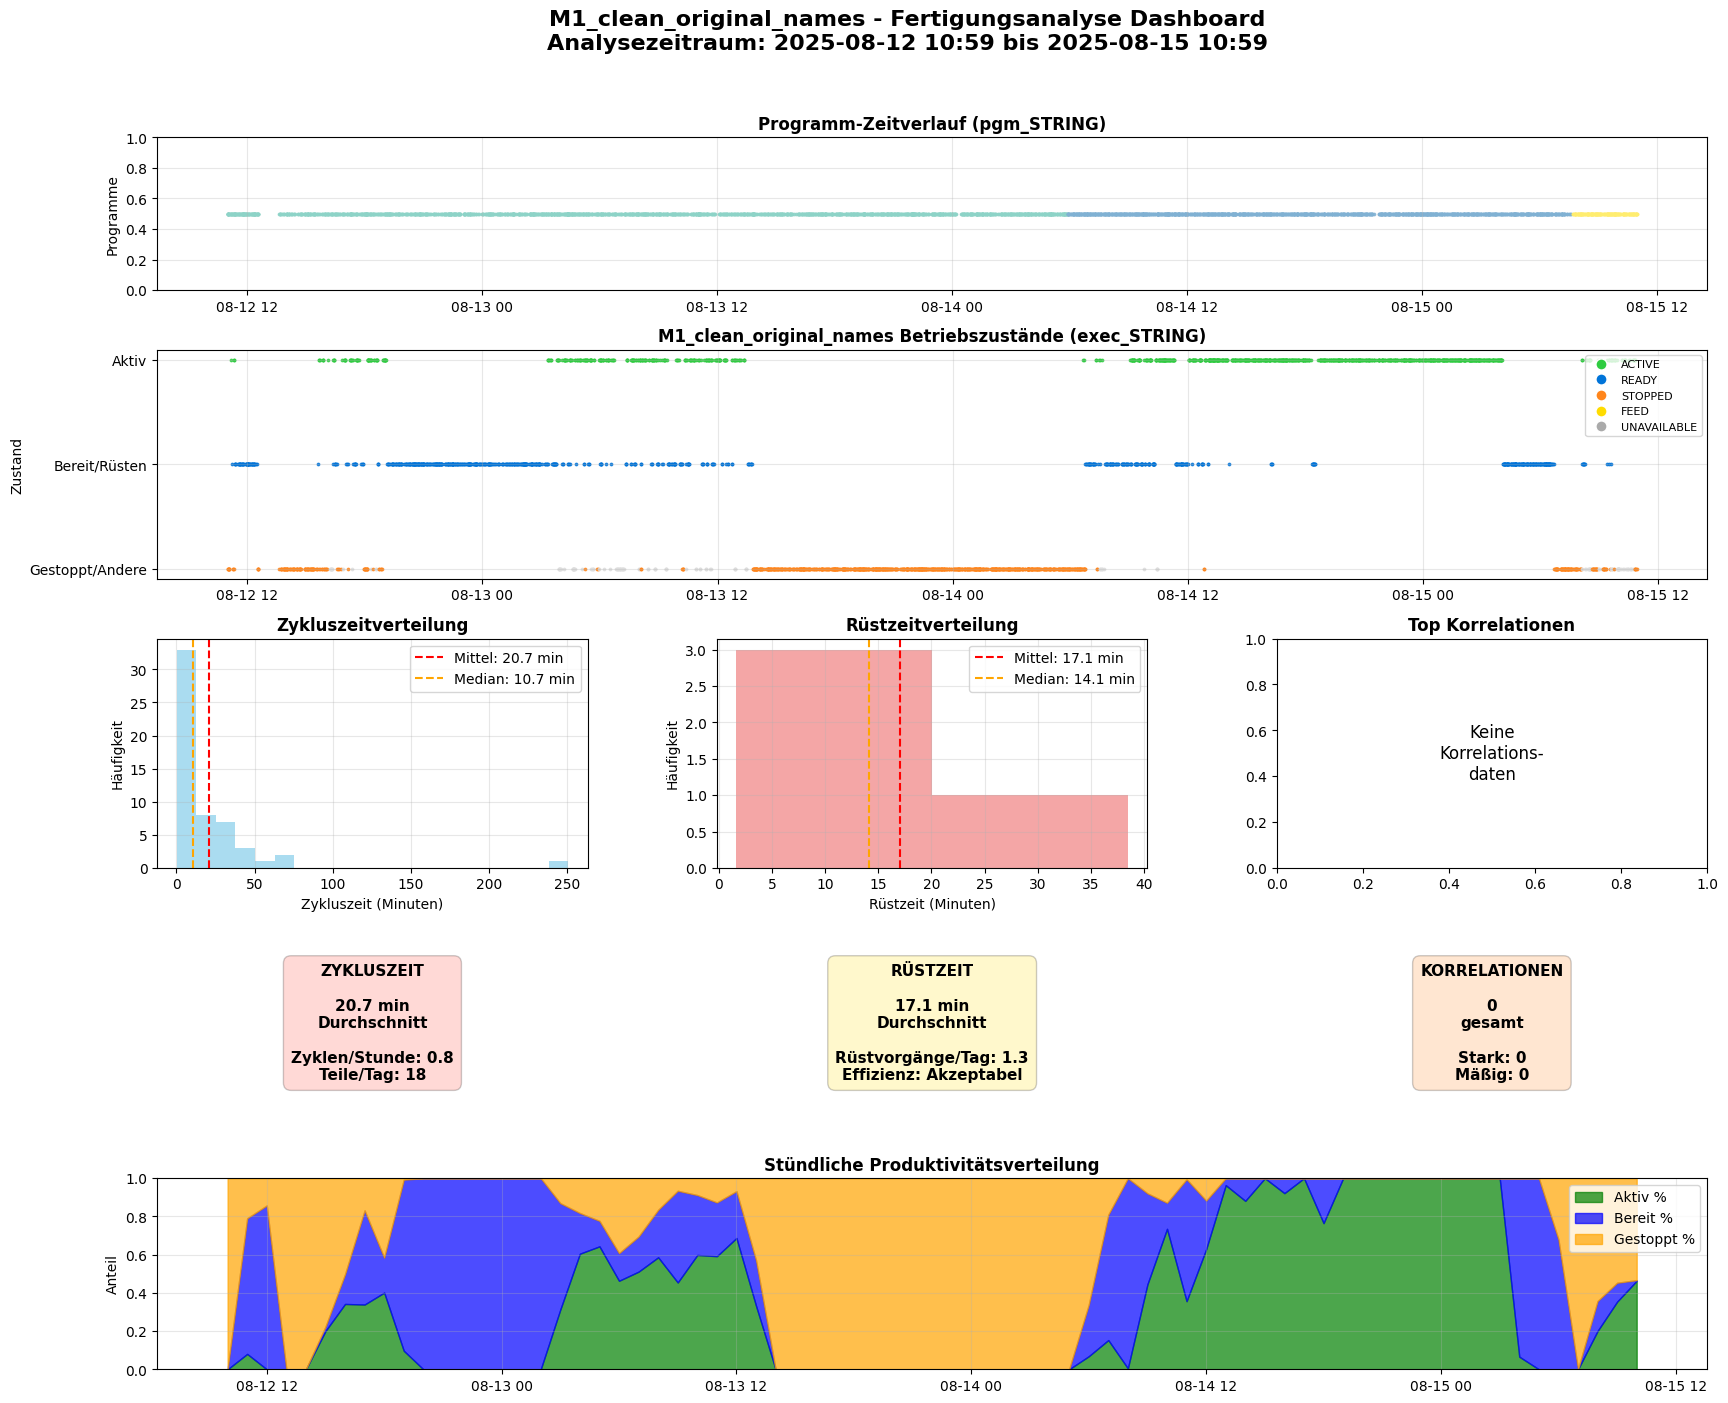

✅ Dashboard erfolgreich erstellt für M1_clean_original_names


In [48]:
def create_single_machine_dashboard(df, machine_name, machine_states, cycle_data, setup_data, dependency_data):
    """Erstelle Dashboard für eine einzelne Maschine"""
    if not SHOW_DASHBOARD:
        print("📊 Dashboard-Anzeige deaktiviert (SHOW_DASHBOARD = False)")
        return
    
    print(f"\n" + "="*70)
    print(f"📊 ERSTELLE DASHBOARD: {machine_name}")
    print("="*70)
    
    # Stelle sicher, dass matplotlib inline anzeigt (für Jupyter Notebook)
    try:
        get_ipython().run_line_magic('matplotlib', 'inline')
    except:
        pass  # Falls nicht in Jupyter, ignorieren
    
    plt.close('all')  # Schließe alle vorherigen Plots
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(5, 3, height_ratios=[0.8, 1.2, 1.2, 1, 1], hspace=0.3, wspace=0.3)
    
    # Haupttitel
    fig.suptitle(f'{machine_name} - Fertigungsanalyse Dashboard\n' + 
                 f'Analysezeitraum: {df["datetime"].min().strftime("%Y-%m-%d %H:%M")} bis ' +
                 f'{df["datetime"].max().strftime("%Y-%m-%d %H:%M")}', 
                 fontsize=16, fontweight='bold', y=0.96)
    
    # 1. Programm-Timeline
    ax1 = fig.add_subplot(gs[0, :])
    if 'pgm_STRING' in df.columns:
        sample_df = df.sample(min(3000, len(df))).sort_values('datetime')
        
        unique_programs = sample_df['pgm_STRING'].dropna().unique()
        if len(unique_programs) > 0:
            program_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_programs)))
            program_color_map = dict(zip(unique_programs, program_colors))
            
            for idx, row in sample_df.iterrows():
                program = row['pgm_STRING']
                if pd.notna(program):
                    color = program_color_map.get(program, 'gray')
                    ax1.scatter(row['datetime'], 0.5, c=color, s=3, alpha=0.8)
    
    ax1.set_title('Programm-Zeitverlauf (pgm_STRING)', fontweight='bold')
    ax1.set_ylabel('Programme')
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)
    
    # 2. Maschinenstatus-Timeline
    ax2 = fig.add_subplot(gs[1, :])
    if 'exec_STRING' in df.columns:
        sample_df = df.sample(min(3000, len(df))).sort_values('datetime')
        
        state_colors = {
            'ACTIVE': '#2ECC40',      # Grün
            'READY': '#0074D9',       # Blau
            'STOPPED': '#FF851B',     # Orange
            'FEED': '#FFDC00',        # Gelb
            'UNAVAILABLE': '#AAAAAA'  # Grau
        }
        
        for idx, row in sample_df.iterrows():
            state = row['exec_STRING']
            if pd.notna(state):
                color = state_colors.get(state, '#DDDDDD')
                y_pos = 1 if state == 'ACTIVE' else 0.5 if state in ['READY', 'FEED'] else 0
                ax2.scatter(row['datetime'], y_pos, c=color, s=3, alpha=0.8)
    
    ax2.set_title(f'{machine_name} Betriebszustände (exec_STRING)', fontweight='bold')
    ax2.set_ylabel('Zustand')
    ax2.set_yticks([0, 0.5, 1])
    ax2.set_yticklabels(['Gestoppt/Andere', 'Bereit/Rüsten', 'Aktiv'])
    ax2.grid(True, alpha=0.3)
    
    # Legende
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=color, markersize=8, label=state)
                     for state, color in state_colors.items()]
    ax2.legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    # 3. Zykluszeit-Verteilung
    ax3 = fig.add_subplot(gs[2, 0])
    if cycle_data and len(cycle_data.get('raw_cycles', [])) > 0:
        cycle_durations = [c['duration_minutes'] for c in cycle_data['raw_cycles']]
        ax3.hist(cycle_durations, bins=min(20, len(cycle_durations)//2), alpha=0.7, color='skyblue')
        ax3.axvline(cycle_data['mean_minutes'], color='red', linestyle='--', label=f'Mittel: {cycle_data["mean_minutes"]:.1f} min')
        ax3.axvline(cycle_data['median_minutes'], color='orange', linestyle='--', label=f'Median: {cycle_data["median_minutes"]:.1f} min')
        ax3.set_title('Zykluszeitverteilung', fontweight='bold')
        ax3.set_xlabel('Zykluszeit (Minuten)')
        ax3.set_ylabel('Häufigkeit')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Keine\nZykluszeit-\ndaten', ha='center', va='center', 
                transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Zykluszeit-Verteilung', fontweight='bold')
    
    # 4. Rüstzeit-Verteilung
    ax4 = fig.add_subplot(gs[2, 1])
    if setup_data and len(setup_data.get('raw_setup_periods', [])) > 0:
        setup_durations = [s['setup_duration_minutes'] for s in setup_data['raw_setup_periods']]
        ax4.hist(setup_durations, bins=min(15, len(setup_durations)//2), alpha=0.7, color='lightcoral')
        ax4.axvline(setup_data['mean_minutes'], color='red', linestyle='--', label=f'Mittel: {setup_data["mean_minutes"]:.1f} min')
        ax4.axvline(setup_data['median_minutes'], color='orange', linestyle='--', label=f'Median: {setup_data["median_minutes"]:.1f} min')
        ax4.set_title('Rüstzeitverteilung', fontweight='bold')
        ax4.set_xlabel('Rüstzeit (Minuten)')
        ax4.set_ylabel('Häufigkeit')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Keine\nRüstzeit-\ndaten', ha='center', va='center', 
                transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Rüstzeit-Verteilung', fontweight='bold')
    
    # 5. Korrelations-Heatmap (Top 10)
    ax5 = fig.add_subplot(gs[2, 2])
    if dependency_data and len(dependency_data.get('top_correlations', [])) > 0:
        top_corr = dependency_data['top_correlations'][:8]  # Top 8 für bessere Darstellung
        corr_values = [abs(c['correlation']) for c in top_corr]
        var_pairs = [f"{c['variable1'][:10]}...\n{c['variable2'][:10]}..." for c in top_corr]
        
        bars = ax5.barh(range(len(corr_values)), corr_values, color='lightgreen')
        ax5.set_yticks(range(len(var_pairs)))
        ax5.set_yticklabels(var_pairs, fontsize=8)
        ax5.set_xlabel('|Korrelation|')
        ax5.set_title('Top Korrelationen', fontweight='bold')
        ax5.grid(True, alpha=0.3)
        
        # Färbe Balken nach Stärke
        for bar, corr in zip(bars, [c['correlation'] for c in top_corr]):
            if abs(corr) > 0.7:
                bar.set_color('darkgreen')
            elif abs(corr) > 0.5:
                bar.set_color('orange')
    else:
        ax5.text(0.5, 0.5, 'Keine\nKorrelations-\ndaten', ha='center', va='center', 
                transform=ax5.transAxes, fontsize=12)
        ax5.set_title('Top Korrelationen', fontweight='bold')
    
    # 6. Kennzahlen-Karten
    # Zykluszeit-Karte
    ax6 = fig.add_subplot(gs[3, 0])
    ax6.axis('off')
    
    if cycle_data:
        cycle_text = f"ZYKLUSZEIT\n\n{cycle_data['mean_minutes']:.1f} min\nDurchschnitt\n\n"
        cycle_text += f"Zyklen/Stunde: {cycle_data['cycles_per_hour']:.1f}\n"
        cycle_text += f"Teile/Tag: {cycle_data.get('parts_per_day', 0):.0f}"
        
        cv = cycle_data.get('coefficient_of_variation', 1)
        color = '#2ECC40' if cv < 0.3 else '#FF851B' if cv < 0.6 else '#FF4136'
    else:
        cycle_text = "ZYKLUSZEIT\n\nKeine Daten\nverfügbar"
        color = '#AAAAAA'
    
    ax6.text(0.5, 0.5, cycle_text, ha='center', va='center', transform=ax6.transAxes,
             fontsize=11, fontweight='bold', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor=color, alpha=0.2))
    
    # Rüstzeit-Karte
    ax7 = fig.add_subplot(gs[3, 1])
    ax7.axis('off')
    
    if setup_data:
        setup_text = f"RÜSTZEIT\n\n{setup_data['mean_minutes']:.1f} min\nDurchschnitt\n\n"
        setup_text += f"Rüstvorgänge/Tag: {setup_data['setups_per_day']:.1f}\n"
        setup_text += f"Effizienz: {setup_data.get('efficiency_rating', 'N/A')}"
        
        eff = setup_data.get('efficiency_rating', 'Schlecht')
        color = ('#2ECC40' if eff in ['Exzellent', 'Gut'] else 
                 '#FFDC00' if eff == 'Akzeptabel' else 
                 '#FF851B' if eff == 'Verbesserungsbedürftig' else '#FF4136')
    else:
        setup_text = "RÜSTZEIT\n\nKeine Daten\nverfügbar"
        color = '#AAAAAA'
    
    ax7.text(0.5, 0.5, setup_text, ha='center', va='center', transform=ax7.transAxes,
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor=color, alpha=0.2))
    
    # Korrelations-Karte
    ax8 = fig.add_subplot(gs[3, 2])
    ax8.axis('off')
    
    if dependency_data:
        corr_counts = dependency_data['correlation_counts']
        dep_text = f"KORRELATIONEN\n\n{corr_counts['total']}\ngesamt\n\n"
        dep_text += f"Stark: {corr_counts['strong']}\n"
        dep_text += f"Mäßig: {corr_counts['moderate']}"
        
        color = '#2ECC40' if corr_counts['strong'] > 0 else '#FF851B'
    else:
        dep_text = "KORRELATIONEN\n\nKeine Analyse\nverfügbar"
        color = '#AAAAAA'
    
    ax8.text(0.5, 0.5, dep_text, ha='center', va='center', transform=ax8.transAxes,
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor=color, alpha=0.2))
    
    # 7. Produktivitäts-Timeline (letzte 24h oder verfügbarer Zeitraum)
    ax9 = fig.add_subplot(gs[4, :])
    if machine_states and 'analysis_df' in machine_states:
        analysis_df = machine_states['analysis_df']
        
        # Gruppiere nach Stunden für bessere Darstellung
        analysis_df['hour_period'] = analysis_df['datetime'].dt.floor('H')
        hourly_stats = analysis_df.groupby('hour_period').agg({
            'is_active': 'mean',
            'is_ready': 'mean',
            'is_stopped': 'mean'
        }).reset_index()
        
        ax9.fill_between(hourly_stats['hour_period'], 0, hourly_stats['is_active'], 
                        alpha=0.7, color='green', label='Aktiv %')
        ax9.fill_between(hourly_stats['hour_period'], hourly_stats['is_active'], 
                        hourly_stats['is_active'] + hourly_stats['is_ready'], 
                        alpha=0.7, color='blue', label='Bereit %')
        ax9.fill_between(hourly_stats['hour_period'], 
                        hourly_stats['is_active'] + hourly_stats['is_ready'], 1, 
                        alpha=0.7, color='orange', label='Gestoppt %')
    
    ax9.set_title('Stündliche Produktivitätsverteilung', fontweight='bold')
    ax9.set_ylabel('Anteil')
    ax9.set_ylim(0, 1)
    ax9.legend(loc='upper right')
    ax9.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.94])
    
    # Speichere Dashboard als Bild
    dashboard_file = f"dashboard_{machine_name}_{datetime.now().strftime('%Y%m%d_%H%M')}.png"
    plt.savefig(dashboard_file, dpi=150, bbox_inches='tight')
    print(f"💾 Dashboard gespeichert als: {dashboard_file}")
    
    # Versuche Anzeige im Notebook
    plt.show()
    
    print(f"✅ Dashboard erfolgreich erstellt für {machine_name}")

# Erstelle Dashboard
if df is not None:
    create_single_machine_dashboard(df, machine_name, machine_states, cycle_analysis, setup_analysis, dependency_analysis)

## 7. Automatisierter Geschäftsbericht

In [ ]:
def generate_single_machine_report(machine_name, df, machine_states, cycle_analysis, setup_analysis, dependency_analysis):
    """Generiere automatisierten Bericht für eine einzelne Maschine"""
    print(f"\n" + "="*80)
    print(f"📋 AUTOMATISIERTER GESCHÄFTSBERICHT: {machine_name}")
    print(f"📋 Einzelmaschinen-Analyse mit Geschäftslogik")
    print("="*80)
    
    report_time = datetime.now()
    analysis_start = df['datetime'].min()
    analysis_end = df['datetime'].max()
    analysis_duration = (analysis_end - analysis_start).total_seconds() / 3600
    
    print(f"\n🏭 ANALYSE-ÜBERSICHT:")
    print(f"• Maschine: {machine_name}")
    print(f"• Berichtsdatum: {report_time.strftime('%Y-%m-%d %H:%M')}")
    print(f"• Analysezeitraum: {analysis_start.strftime('%Y-%m-%d %H:%M')} bis {analysis_end.strftime('%Y-%m-%d %H:%M')}")
    print(f"• Analysedauer: {analysis_duration:.1f} Stunden ({analysis_duration/24:.1f} Tage)")
    print(f"• Datenpunkte: {len(df):,}")
    print(f"• Datenqualität: {((df['exec_STRING'].notna().sum() + df['pgm_STRING'].notna().sum()) / (2 * len(df)) * 100):.1f}% vollständig")
    
    # Gesamtbewertung der Maschine
    overall_score = 0
    max_score = 0
    
    print(f"\n" + "="*60)
    print(f"🎯 FORSCHUNGSFRAGE 1: ZYKLUSZEIT-ANALYSE")
    print("="*60)
    
    if cycle_analysis:
        print(f"✅ ZYKLUSZEIT-ERGEBNISSE:")
        print(f"   📊 Durchschnittliche Zykluszeit: {cycle_analysis['mean_minutes']:.2f} Minuten")
        print(f"   ⚡ Produktionsrate: {cycle_analysis['cycles_per_hour']:.1f} Zyklen pro Stunde")
        print(f"   📈 Teile pro Tag (24h): {cycle_analysis.get('parts_per_day', 0):.0f}")
        print(f"   🎯 Konsistenz (CV): {cycle_analysis['coefficient_of_variation']:.3f}")
        print(f"   🔧 Verarbeitete Programme: {cycle_analysis['unique_programs']}")
        print(f"   📋 Analysierte Zyklen: {cycle_analysis['total_cycles']}")
        
        # Bewertung der Zykluszeit-Leistung
        cv = cycle_analysis['coefficient_of_variation']
        if cv < 0.2:
            cycle_score = 10
            print(f"   💡 BEWERTUNG: ✅ Exzellente Konsistenz (CV < 0.2)")
        elif cv < 0.4:
            cycle_score = 8
            print(f"   💡 BEWERTUNG: 🟢 Gute Konsistenz (CV < 0.4)")
        elif cv < 0.6:
            cycle_score = 6
            print(f"   💡 BEWERTUNG: 🟡 Mäßige Konsistenz (CV < 0.6)")
        else:
            cycle_score = 4
            print(f"   💡 BEWERTUNG: 🔴 Schlechte Konsistenz (CV ≥ 0.6) - Prozess optimieren")
        
        overall_score += cycle_score
        max_score += 10
        
        # Programmspezifische Einblicke
        if cycle_analysis.get('program_cycles'):
            print(f"\n   📋 PROGRAMMSPEZIFISCHE DETAILS:")
            for prog, data in list(cycle_analysis['program_cycles'].items())[:3]:
                print(f"      {prog}: {data['avg_minutes']:.2f} min durchschnittlich (n={data['count']})")
    else:
        print(f"❌ ZYKLUSZEIT-ANALYSE:")
        print(f"   Keine Zyklusdaten verfügbar oder zu wenig Daten")
        print(f"   💡 EMPFEHLUNG: Datenerfassung prüfen oder längeren Zeitraum analysieren")
        cycle_score = 0
        max_score += 10
    
    print(f"\n" + "="*60)
    print(f"🔧 FORSCHUNGSFRAGE 2: RÜSTZEIT-ANALYSE")
    print("="*60)
    
    if setup_analysis:
        print(f"✅ RÜSTZEIT-ERGEBNISSE:")
        print(f"   🔧 Durchschnittliche Rüstzeit: {setup_analysis['mean_minutes']:.2f} Minuten")
        print(f"   🔄 Rüstvorgänge pro Tag: {setup_analysis['setups_per_day']:.1f}")
        print(f"   ⏱️ Tägliche Rüstzeit: {setup_analysis['daily_setup_hours']:.1f} Stunden")
        print(f"   📊 Rüstzeit-Anteil: {(setup_analysis['daily_setup_hours'] / 24 * 100):.1f}% des Tages")
        print(f"   🎯 Effizienz-Rating: {setup_analysis['efficiency_rating']}")
        print(f"   📋 Analysierte Rüstvorgänge: {setup_analysis['valid_setups']}")
        
        # Bewertung der Rüstzeit-Leistung
        mean_setup = setup_analysis['mean_minutes']
        if mean_setup < 5:
            setup_score = 10
            print(f"   💡 BEWERTUNG: ✅ Exzellente Rüsteffizienz (< 5 min)")
        elif mean_setup < 15:
            setup_score = 8
            print(f"   💡 BEWERTUNG: 🟢 Gute Rüsteffizienz (< 15 min)")
        elif mean_setup < 30:
            setup_score = 6
            print(f"   💡 BEWERTUNG: 🟡 Akzeptable Rüsteffizienz (< 30 min)")
        elif mean_setup < 60:
            setup_score = 4
            print(f"   💡 BEWERTUNG: 🟠 Verbesserungsbedürftig (< 60 min)")
        else:
            setup_score = 2
            print(f"   💡 BEWERTUNG: 🔴 Dringend optimieren! (≥ 60 min)")
        
        overall_score += setup_score
        max_score += 10
        
        # Zeitauswirkung
        if setup_analysis['daily_setup_hours'] > 4:
            print(f"   ⚠️ KRITISCH: Sehr hoher Rüstzeitverlust - Batch-Produktion erwägen")
        elif setup_analysis['daily_setup_hours'] > 2:
            print(f"   🟡 ACHTUNG: Mittlerer Rüstzeitverlust - Überwachung empfohlen")
        else:
            print(f"   ✅ GUT: Geringer Rüstzeitverlust")
    else:
        print(f"❌ RÜSTZEIT-ANALYSE:")
        print(f"   Keine Rüstdaten verfügbar oder zu wenige Programmwechsel")
        print(f"   💡 EMPFEHLUNG: Mehr Programmwechsel oder längeren Zeitraum analysieren")
        setup_score = 5  # Neutral da möglicherweise wenig Rüstbedarf
        max_score += 10
    
    print(f"\n" + "="*60)
    print(f"🔗 FORSCHUNGSFRAGE 3: VARIABLENABHÄNGIGKEITS-ANALYSE")
    print("="*60)
    
    if dependency_analysis:
        corr_counts = dependency_analysis['correlation_counts']
        print(f"✅ KORRELATIONS-ERGEBNISSE:")
        print(f"   📊 Analysierte Variablen: {dependency_analysis['variables_analyzed']}")
        print(f"   🔗 Signifikante Korrelationen: {corr_counts['total']}")
        print(f"   💪 Starke Korrelationen (|r| > 0.7): {corr_counts['strong']}")
        print(f"   🟡 Mäßige Korrelationen (0.5-0.7): {corr_counts['moderate']}")
        print(f"   📊 Schwache Korrelationen (0.3-0.5): {corr_counts['weak']}")
        
        # Bewertung der Abhängigkeitsanalyse
        if corr_counts['strong'] > 5:
            dep_score = 10
            print(f"   💡 BEWERTUNG: ✅ Hohe Interdependenz - Exzellent für prädiktive Wartung")
        elif corr_counts['strong'] > 2:
            dep_score = 8
            print(f"   💡 BEWERTUNG: 🟢 Gute Interdependenz - Potenzial für Überwachung")
        elif corr_counts['total'] > 5:
            dep_score = 6
            print(f"   💡 BEWERTUNG: 🟡 Mittlere Abhängigkeiten - Fokus auf starke Korrelationen")
        elif corr_counts['total'] > 0:
            dep_score = 4
            print(f"   💡 BEWERTUNG: 🟠 Wenige Abhängigkeiten - Individuelle Überwachung")
        else:
            dep_score = 2
            print(f"   💡 BEWERTUNG: 🔴 Keine Korrelationen - Datenqualität prüfen")
        
        overall_score += dep_score
        max_score += 10
        
        # Top Korrelationen zeigen
        if dependency_analysis.get('top_correlations'):
            print(f"\n   🏆 TOP 3 KORRELATIONEN:")
            for i, corr in enumerate(dependency_analysis['top_correlations'][:3], 1):
                var1 = corr['variable1'][:15] + '...' if len(corr['variable1']) > 15 else corr['variable1']
                var2 = corr['variable2'][:15] + '...' if len(corr['variable2']) > 15 else corr['variable2']
                print(f"      {i}. {var1} ↔ {var2}: r = {corr['correlation']:+.3f} ({corr['strength']})")
    else:
        print(f"❌ ABHÄNGIGKEITS-ANALYSE:")
        print(f"   Keine Korrelationsanalyse verfügbar")
        print(f"   💡 EMPFEHLUNG: Datenqualität und -vollständigkeit prüfen")
        dep_score = 0
        max_score += 10
    
    # GESAMTBEWERTUNG
    print(f"\n" + "="*60)
    print(f"🏆 GESAMTBEWERTUNG DER MASCHINE")
    print("="*60)
    
    overall_percentage = (overall_score / max_score * 100) if max_score > 0 else 0
    
    print(f"📊 GESAMTSCORE: {overall_score}/{max_score} Punkte ({overall_percentage:.1f}%)")
    
    if overall_percentage >= 80:
        rating = "EXZELLENT"
        color_emoji = "🟢"
        recommendation = "Aktuelle Leistung beibehalten und als Benchmark verwenden"
    elif overall_percentage >= 60:
        rating = "GUT"
        color_emoji = "🟡"
        recommendation = "Kleinere Optimierungen durchführen"
    elif overall_percentage >= 40:
        rating = "VERBESSERUNGSBEDÜRFTIG"
        color_emoji = "🟠"
        recommendation = "Gezielte Optimierungsmaßnahmen implementieren"
    else:
        rating = "KRITISCH"
        color_emoji = "🔴"
        recommendation = "Sofortige Maßnahmen erforderlich"
    
    print(f"🎯 GESAMTBEWERTUNG: {color_emoji} {rating}")
    print(f"💡 EMPFEHLUNG: {recommendation}")
    
    # SPEZIFISCHE HANDLUNGSEMPFEHLUNGEN
    print(f"\n" + "="*60)
    print(f"🎯 HANDLUNGSEMPFEHLUNGEN")
    print("="*60)
    
    recommendations = []
    
    # Zykluszeit-Empfehlungen
    if cycle_analysis:
        cv = cycle_analysis['coefficient_of_variation']
        if cv > 0.6:
            recommendations.append("🎯 PRIORITÄT 1: Zykluszeit-Konsistenz verbessern - Prozessstabilität untersuchen")
        elif cv > 0.4:
            recommendations.append("🔍 Zykluszeit-Variation überwachen und Ursachen identifizieren")
        
        if cycle_analysis['cycles_per_hour'] < 1:
            recommendations.append("⚡ Produktionsrate analysieren - Möglichkeit zur Taktzeit-Optimierung prüfen")
    
    # Rüstzeit-Empfehlungen
    if setup_analysis:
        mean_setup = setup_analysis['mean_minutes']
        if mean_setup > 30:
            recommendations.append("🔧 PRIORITÄT 1: Rüstzeiten drastisch reduzieren - SMED-Methoden implementieren")
        elif mean_setup > 15:
            recommendations.append("🔧 Rüstzeit-Optimierung: Rüstprozesse standardisieren und dokumentieren")
        
        if setup_analysis['daily_setup_hours'] > 4:
            recommendations.append("📋 Produktionsplanung optimieren - Batch-Größen überdenken")
    
    # Abhängigkeits-Empfehlungen
    if dependency_analysis:
        strong_corr = dependency_analysis['correlation_counts']['strong']
        if strong_corr > 3:
            recommendations.append("🔗 Prädiktive Wartung: Starke Korrelationen für Condition Monitoring nutzen")
        elif strong_corr > 0:
            recommendations.append("📊 Prozessüberwachung: Schlüsselkorrelationen kontinuierlich verfolgen")
    
    # Allgemeine Empfehlungen basierend auf Maschinenstatus
    if machine_states:
        active_pct = machine_states['stats']['active_percentage']
        if active_pct < 30:
            recommendations.append("⚠️ KRITISCH: Sehr geringe Produktivität - Stillstandsursachen analysieren")
        elif active_pct < 50:
            recommendations.append("🟡 Produktivität verbessern - Maschinenauslastung optimieren")
    
    if recommendations:
        for i, rec in enumerate(recommendations, 1):
            print(f"   {i}. {rec}")
    else:
        print(f"   ✅ Aktuelle Leistung ist zufriedenstellend")
        print(f"   📊 Regelmäßige Überwachung zur Leistungserhaltung empfohlen")
    
    # NÄCHSTE SCHRITTE
    print(f"\n" + "="*60)
    print(f"🔄 NÄCHSTE SCHRITTE")
    print("="*60)
    
    print(f"   1. 📋 Sofortige Maßnahmen (diese Woche):")
    print(f"      • Ergebnisse mit Produktionsteam besprechen")
    print(f"      • Prioritäts-1-Empfehlungen angehen")
    
    print(f"   2. 📊 Mittelfristige Maßnahmen (nächster Monat):")
    print(f"      • Kontinuierliche Überwachung einrichten")
    print(f"      • Optimierungsmaßnahmen implementieren")
    
    print(f"   3. 🎯 Langfristige Maßnahmen (nächstes Quartal):")
    print(f"      • Benchmarking mit anderen Maschinen")
    print(f"      • Prädiktive Wartungsstrategien entwickeln")
    
    print(f"   4. 🔄 Regelmäßige Wiederholung:")
    print(f"      • Wöchentliche Kurzanalyse")
    print(f"      • Monatliche Detailanalyse")
    
    print(f"\n" + "="*80)
    print(f"✅ AUTOMATISIERTER BERICHT ABGESCHLOSSEN: {machine_name}")
    print(f"📋 Bereit für Produktionsteam-Review und Maßnahmenumsetzung")
    print(f"⏰ Nächste Analyse empfohlen: {(report_time + timedelta(days=7)).strftime('%Y-%m-%d')}")
    print("="*80)
    
    # Rückgabe strukturierter Bericht für Export
    return {
        'machine_name': machine_name,
        'report_date': report_time.isoformat(),
        'analysis_period': {
            'start': analysis_start.isoformat(),
            'end': analysis_end.isoformat(),
            'duration_hours': analysis_duration
        },
        'data_quality': {
            'total_records': len(df),
            'completeness_percentage': ((df['exec_STRING'].notna().sum() + df['pgm_STRING'].notna().sum()) / (2 * len(df)) * 100)
        },
        'results': {
            'cycle_analysis': {
                'available': cycle_analysis is not None,
                'mean_minutes': cycle_analysis['mean_minutes'] if cycle_analysis else None,
                'cycles_per_hour': cycle_analysis['cycles_per_hour'] if cycle_analysis else None,
                'consistency_cv': cycle_analysis['coefficient_of_variation'] if cycle_analysis else None,
                'score': cycle_score
            },
            'setup_analysis': {
                'available': setup_analysis is not None,
                'mean_minutes': setup_analysis['mean_minutes'] if setup_analysis else None,
                'setups_per_day': setup_analysis['setups_per_day'] if setup_analysis else None,
                'efficiency_rating': setup_analysis['efficiency_rating'] if setup_analysis else None,
                'score': setup_score
            },
            'dependency_analysis': {
                'available': dependency_analysis is not None,
                'total_correlations': dependency_analysis['correlation_counts']['total'] if dependency_analysis else 0,
                'strong_correlations': dependency_analysis['correlation_counts']['strong'] if dependency_analysis else 0,
                'score': dep_score
            }
        },
        'overall_assessment': {
            'score': overall_score,
            'max_score': max_score,
            'percentage': overall_percentage,
            'rating': rating,
            'recommendation': recommendation
        },
        'action_items': recommendations,
        'next_analysis_date': (report_time + timedelta(days=7)).isoformat()
    }

# Generiere automatisierten Bericht
if df is not None:
    business_report = generate_single_machine_report(machine_name, df, machine_states, cycle_analysis, setup_analysis, dependency_analysis)
    print(f"\n✅ Automatisierter Geschäftsbericht erstellt")
else:
    business_report = None
    print(f"\n❌ Kann keinen Bericht ohne gültige Daten erstellen")

## 8. Export und Dokumentation

In [ ]:
def export_analysis_results(machine_name, business_report, cycle_analysis, setup_analysis, dependency_analysis):
    """Exportiere Analyseergebnisse in verschiedene Formate"""
    if not (EXPORT_REPORTS or EXPORT_SUMMARY):
        print("📁 Export deaktiviert (EXPORT_REPORTS und EXPORT_SUMMARY = False)")
        return
    
    print(f"\n" + "="*70)
    print(f"📁 EXPORTIERE ANALYSEERGEBNISSE: {machine_name}")
    print("="*70)
    
    # Erstelle Output-Verzeichnis
    output_dir = Path('../processed_data')
    output_dir.mkdir(exist_ok=True)
    
    # Datum für Dateinamen
    date_str = datetime.now().strftime('%Y%m%d_%H%M')
    machine_clean = re.sub(r'[^a-zA-Z0-9_-]', '_', machine_name)
    
    exported_files = []
    
    # 1. Geschäftsbericht (JSON)
    if EXPORT_REPORTS and business_report:
        business_file = output_dir / f'{machine_clean}_geschaeftsbericht_{date_str}.json'
        with open(business_file, 'w', encoding='utf-8') as f:
            json.dump(business_report, f, indent=2, default=str, ensure_ascii=False)
        exported_files.append(str(business_file))
        print(f"✅ Geschäftsbericht: {business_file.name}")
    
    # 2. Detaillierte Ergebnisse (JSON)
    if EXPORT_REPORTS:
        detailed_results = {
            'machine_name': machine_name,
            'analysis_timestamp': datetime.now().isoformat(),
            'cycle_analysis': cycle_analysis,
            'setup_analysis': setup_analysis,
            'dependency_analysis': {
                'correlation_counts': dependency_analysis['correlation_counts'] if dependency_analysis else {},
                'top_5_correlations': dependency_analysis['top_correlations'][:5] if dependency_analysis and dependency_analysis.get('top_correlations') else [],
                'variables_analyzed': dependency_analysis['variables_analyzed'] if dependency_analysis else 0
            } if dependency_analysis else None
        }
        
        detailed_file = output_dir / f'{machine_clean}_detailanalyse_{date_str}.json'
        with open(detailed_file, 'w', encoding='utf-8') as f:
            json.dump(detailed_results, f, indent=2, default=str, ensure_ascii=False)
        exported_files.append(str(detailed_file))
        print(f"✅ Detailanalyse: {detailed_file.name}")
    
    # 3. Zusammenfassung (TXT)
    if EXPORT_SUMMARY and business_report:
        summary_file = output_dir / f'{machine_clean}_zusammenfassung_{date_str}.txt'
        
        with open(summary_file, 'w', encoding='utf-8') as f:
            f.write(f"CNC EINZELMASCHINEN-ANALYSE - ZUSAMMENFASSUNG\n")
            f.write(f"=" * 60 + "\n\n")
            
            f.write(f"MASCHINE: {machine_name}\n")
            f.write(f"ANALYSEDATUM: {business_report['report_date'][:19]}\n")
            f.write(f"ANALYSEZEITRAUM: {business_report['analysis_period']['duration_hours']:.1f} Stunden\n")
            f.write(f"DATENQUALITÄT: {business_report['data_quality']['completeness_percentage']:.1f}% vollständig\n\n")
            
            # Gesamtbewertung
            overall = business_report['overall_assessment']
            f.write(f"GESAMTBEWERTUNG: {overall['rating']} ({overall['percentage']:.1f}%)\n")
            f.write(f"SCORE: {overall['score']}/{overall['max_score']} Punkte\n")
            f.write(f"EMPFEHLUNG: {overall['recommendation']}\n\n")
            
            # Ergebnisse
            results = business_report['results']
            
            if results['cycle_analysis']['available']:
                f.write(f"ZYKLUSZEIT:\n")
                f.write(f"  Durchschnitt: {results['cycle_analysis']['mean_minutes']:.2f} Minuten\n")
                f.write(f"  Zyklen/Stunde: {results['cycle_analysis']['cycles_per_hour']:.1f}\n")
                f.write(f"  Konsistenz (CV): {results['cycle_analysis']['consistency_cv']:.3f}\n\n")
            else:
                f.write(f"ZYKLUSZEIT: Keine Daten verfügbar\n\n")
            
            if results['setup_analysis']['available']:
                f.write(f"RÜSTZEIT:\n")
                f.write(f"  Durchschnitt: {results['setup_analysis']['mean_minutes']:.2f} Minuten\n")
                f.write(f"  Rüstvorgänge/Tag: {results['setup_analysis']['setups_per_day']:.1f}\n")
                f.write(f"  Effizienz: {results['setup_analysis']['efficiency_rating']}\n\n")
            else:
                f.write(f"RÜSTZEIT: Keine Daten verfügbar\n\n")
            
            if results['dependency_analysis']['available']:
                f.write(f"KORRELATIONEN:\n")
                f.write(f"  Signifikante Korrelationen: {results['dependency_analysis']['total_correlations']}\n")
                f.write(f"  Starke Korrelationen: {results['dependency_analysis']['strong_correlations']}\n\n")

                # Zeige Top-Korrelationen nur wenn vorhanden
                if dependency_analysis and dependency_analysis.get('top_correlations'):
                    f.write(f"  TOP3 Korrelationen:\n")
                    for i, corr in enumerate(dependency_analysis['top_correlations'][:3], 1):
                        var1 = corr['variable1'][:15] + '...' if len(corr['variable1']) > 15 else corr['variable1']
                        var2 = corr['variable2'][:15] + '...' if len(corr['variable2']) > 15 else corr['variable2']
                        f.write(f"    {i}. {var1} ↔ {var2}: r = {corr['correlation']:+.3f} ({corr['strength']})\n")
                else:
                    f.write(f"  (Keine Korrelationen gefunden)\n")
                f.write(f"\n")
            else:
                f.write(f"KORRELATIONEN: Keine Analyse verfügbar\n\n")
            
            # Handlungsempfehlungen
            f.write(f"HANDLUNGSEMPFEHLUNGEN:\n")
            if business_report['action_items']:
                for i, item in enumerate(business_report['action_items'], 1):
                    # Entferne Emojis für Text-Datei
                    clean_item = re.sub(r'[^\w\s:.,!?()-]', '', item)
                    f.write(f"  {i}. {clean_item}\n")
            else:
                f.write(f"  Aktuelle Leistung ist zufriedenstellend\n")
            
            f.write(f"\nNÄCHSTE ANALYSE EMPFOHLEN: {business_report['next_analysis_date'][:10]}\n")
        
        exported_files.append(str(summary_file))
        print(f"✅ Zusammenfassung: {summary_file.name}")
    
    # 4. Excel-kompatible CSV für weitere Analyse
    if EXPORT_REPORTS and cycle_analysis and setup_analysis:
        metrics_data = {
            'Metrik': ['Zykluszeit_Durchschnitt_min', 'Zykluszeit_Konsistenz_CV', 'Zyklen_pro_Stunde',
                      'Ruestzeit_Durchschnitt_min', 'Ruestvorgaenge_pro_Tag', 'Tägliche_Ruestzeit_h'],
            'Wert': [
                cycle_analysis['mean_minutes'],
                cycle_analysis['coefficient_of_variation'],
                cycle_analysis['cycles_per_hour'],
                setup_analysis['mean_minutes'],
                setup_analysis['setups_per_day'],
                setup_analysis['daily_setup_hours']
            ],
            'Bewertung': [
                'Gut' if cycle_analysis['coefficient_of_variation'] < 0.4 else 'Verbesserungsbedürftig',
                'Gut' if cycle_analysis['coefficient_of_variation'] < 0.4 else 'Verbesserungsbedürftig',
                'Gut' if cycle_analysis['cycles_per_hour'] > 1 else 'Prüfen',
                setup_analysis['efficiency_rating'],
                'Gut' if setup_analysis['setups_per_day'] < 5 else 'Hoch',
                'Gut' if setup_analysis['daily_setup_hours'] < 2 else 'Hoch'
            ]
        }
        
        metrics_df = pd.DataFrame(metrics_data)
        csv_file = output_dir / f'{machine_clean}_metriken_{date_str}.csv'
        metrics_df.to_csv(csv_file, index=False, encoding='utf-8')
        exported_files.append(str(csv_file))
        print(f"✅ Metriken-CSV: {csv_file.name}")
    
    print(f"\n📊 EXPORT ZUSAMMENFASSUNG:")
    print(f"   Exportierte Dateien: {len(exported_files)}")
    print(f"   Speicherort: {output_dir.absolute()}")
    print(f"   Maschine: {machine_name}")
    print(f"   Zeitstempel: {date_str}")
    
    return exported_files

# Exportiere alle Ergebnisse
if df is not None and business_report:
    exported_files = export_analysis_results(machine_name, business_report, cycle_analysis, setup_analysis, dependency_analysis)
    
    print(f"\n" + "="*80)
    print(f"🎉 UNIVERSELLE EINZELMASCHINEN-ANALYSE ABGESCHLOSSEN")
    print("="*80)
    
    print(f"\n✅ ERFOLGREICHE ANALYSE VON: {machine_name}")
    print(f"📊 Alle drei Forschungsfragen beantwortet")
    print(f"📋 Automatisierter Bericht generiert")
    print(f"📁 {len(exported_files) if exported_files else 0} Dateien exportiert")
    
    if business_report:
        overall = business_report['overall_assessment']
        print(f"\n🏆 GESAMTBEWERTUNG: {overall['rating']} ({overall['percentage']:.1f}%)")
        print(f"💡 EMPFEHLUNG: {overall['recommendation']}")
    
    print(f"\n🔄 FÜR NÄCHSTE ANALYSE:")
    print(f"   1. Neue CSV-Datei in MACHINE_DATA_PATH eintragen")
    print(f"   2. Alle Zellen der Reihe nach ausführen")
    print(f"   3. Automatische Analyse und Berichtserstellung")
    
    print(f"\n✅ UNIVERSELLES TEMPLATE BEREIT FÜR WIEDERVERWENDUNG")
else:
    print(f"\n❌ ANALYSE NICHT ABGESCHLOSSEN - Daten oder Bericht fehlen")
    print(f"💡 Bitte Konfiguration und Dateipfad überprüfen")